In [1]:

!pip install gdown timm

import gdown
import zipfile
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader, Subset
import torchvision.transforms as transforms
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from PIL import Image
import os
import timm
import numpy as np
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import torch.nn.functional as F


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.8/53.8 kB 3.6 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.

In [2]:
# Download and extract dataset
file_id = '1jsMUDlvsXWQu2BansJz73mAErVyNg_g7'
destination = '/content/shared_file.zip'
gdown.download(id=file_id, output=destination, quiet=False)

# Check if the file is indeed a ZIP file
zip_path = '/content/shared_file.zip'

try:
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        print("ZIP file opened successfully.")
        zip_ref.extractall('/content')
    print("Extraction complete.")
except zipfile.BadZipFile:
    print("Error: The file is not a valid ZIP file or it is corrupted.")
except Exception as e:
    print(f"An unexpected error occurred: {e}")

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Downloading...
From (original): https://drive.google.com/uc?id=1jsMUDlvsXWQu2BansJz73mAErVyNg_g7
From (redirected): https://drive.google.com/uc?id=1jsMUDlvsXWQu2BansJz73mAErVyNg_g7&confirm=t&uuid=15aeac32-eef1-497c-8a41-55e5694b9fe7
To: /content/shared_file.zip
100%|██████████| 1.46G/1.46G [00:20<00:00, 71.0MB/s]


ZIP file opened successfully.
Extraction complete.
Using device: cuda


In [3]:

class ChannelAttention(nn.Module):
    def __init__(self, in_planes, ratio=16):
        super(ChannelAttention, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)

        self.fc1 = nn.Conv2d(in_planes, in_planes // ratio, 1, bias=False)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Conv2d(in_planes // ratio, in_planes, 1, bias=False)

        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = self.fc2(self.relu1(self.fc1(self.avg_pool(x))))
        max_out = self.fc2(self.relu1(self.fc1(self.max_pool(x))))
        out = avg_out + max_out
        return self.sigmoid(out)

class SpatialAttention(nn.Module):
    def __init__(self, kernel_size=7):
        super(SpatialAttention, self).__init__()

        assert kernel_size in (3, 7), 'kernel size must be 3 or 7'
        padding = 3 if kernel_size == 7 else 1

        self.conv1 = nn.Conv2d(2, 1, kernel_size, padding=padding, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        x = torch.cat([avg_out, max_out], dim=1)
        x = self.conv1(x)
        return self.sigmoid(x)

class CBAM(nn.Module):
    def __init__(self, channel, ratio=16, kernel_size=7):
        super(CBAM, self).__init__()
        self.channel_att = ChannelAttention(channel, ratio)
        self.spatial_att = SpatialAttention(kernel_size)

    def forward(self, x):
        x = x * self.channel_att(x)
        x = x * self.spatial_att(x)
        return x

class ConvNeXtWithCBAM(nn.Module):
    def __init__(self, num_classes=1000):
        super(ConvNeXtWithCBAM, self).__init__()
        self.model = timm.create_model("hf_hub:timm/convnext_tiny.fb_in22k", pretrained=True)


        # Add CBAM after each stage
        self.cbam1 = CBAM(96)
        self.cbam2 = CBAM(192)
        self.cbam3 = CBAM(384)
        self.cbam4 = CBAM(768)

        # Replace the final classification layer
        self.model.head.fc = nn.Linear(768, num_classes)

    def forward(self, x):
        x = self.model.stem(x)

        x = self.model.stages[0](x)
        x = self.cbam1(x)

        x = self.model.stages[1](x)
        x = self.cbam2(x)

        x = self.model.stages[2](x)
        x = self.cbam3(x)

        x = self.model.stages[3](x)
        x = self.cbam4(x)

        x = self.model.head(x)
        return x


In [6]:
# Custom Dataset class
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, data, transform=None):
        self.data = data
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path, label = self.data[idx]
        img = Image.open(img_path).convert('RGB')
        if self.transform:
            img = self.transform(img)
        label_tensor = torch.tensor(label, dtype=torch.long)
        return img, label_tensor

# Data augmentation and preprocessing
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomRotation(90),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor()
])

test_val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

# Load data
data_dirs = {
    'T4_Ptrain': ["l0", "l1", "l2"],
    'T4_Ptest': ["l0", "l1", "l2"]
}
data_root = "/content/T4_Pdata"

# Function to load dataset
def load_data(phase, data_dirs, data_root):
    data = []
    for label, folder in enumerate(data_dirs[phase]):
        folder_path = os.path.join(data_root, phase, folder)
        image_files = os.listdir(folder_path)
        for image_file in image_files:
            image_path = os.path.join(folder_path, image_file)
            data.append((image_path, label))
    return data

train_data = load_data('T4_Ptrain', data_dirs, data_root)
test_data = load_data('T4_Ptest', data_dirs, data_root)

# Split train data into training and validation sets
train_data, val_data = train_test_split(train_data, test_size=0.2, stratify=[label for _, label in train_data])

# Create datasets
train_dataset = CustomDataset(train_data, transform=train_transform)
val_dataset = CustomDataset(val_data, transform=test_val_transform)
test_dataset = CustomDataset(test_data, transform=test_val_transform)

# Create DataLoaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Create DataLoaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


# Create the model
num_classes = len(data_dirs['T4_Ptrain'])
model = ConvNeXtWithCBAM(num_classes=num_classes)


# Unfreeze all layers
for param in model.parameters():
    param.requires_grad = True

# Move model to GPU
model.to(device)

# Define optimizer and scheduler
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.0001)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10, verbose=True, min_lr=1e-6)

# Define loss function with class weights
class_counts = np.bincount([label for _, label in train_data])
class_weights = 1. / class_counts
class_weights = class_weights / class_weights.sum()
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)


config.json:   0%|          | 0.00/572 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


In [7]:
# Train the model
num_epochs = 100

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    correct = 0
    total = 0
    progress_bar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}', leave=False)
    for images, labels in progress_bar:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * labels.size(0)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        progress_bar.set_postfix({'Loss': train_loss / total, 'Accuracy': 100 * correct / total})

    train_loss = train_loss / len(train_loader.dataset)
    train_accuracy = 100 * correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * labels.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_loss = val_loss / len(val_loader.dataset)
    val_accuracy = 100 * correct / total
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    print(f'Epoch {epoch+1}/{num_epochs}, '
          f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, '
          f'Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%')

    scheduler.step(val_loss)

# Save the trained model
torch.save(model.state_dict(), '/content/convnext_cbam_model.pth')

Epoch 1/100, Train Loss: 0.9846, Train Accuracy: 43.82%, Val Loss: 0.8801, Val Accuracy: 54.46%


Epoch 2/100, Train Loss: 0.8639, Train Accuracy: 52.99%, Val Loss: 0.9154, Val Accuracy: 53.34%


Epoch 3/100, Train Loss: 0.8091, Train Accuracy: 57.66%, Val Loss: 0.7461, Val Accuracy: 62.26%


Epoch 4/100, Train Loss: 0.7899, Train Accuracy: 60.89%, Val Loss: 0.7152, Val Accuracy: 59.08%


Epoch 5/100, Train Loss: 0.8015, Train Accuracy: 56.42%, Val Loss: 0.6872, Val Accuracy: 64.01%


Epoch 6/100, Train Loss: 0.7019, Train Accuracy: 64.04%, Val Loss: 0.6617, Val Accuracy: 68.15%


Epoch 7/100, Train Loss: 0.6723, Train Accuracy: 65.07%, Val Loss: 0.6447, Val Accuracy: 66.40%


Epoch 8/100, Train Loss: 0.6512, Train Accuracy: 67.82%, Val Loss: 0.6084, Val Accuracy: 67.04%


Epoch 9/100, Train Loss: 0.5930, Train Accuracy: 70.06%, Val Loss: 0.6027, Val Accuracy: 62.90%


Epoch 10/100, Train Loss: 0.5830, Train Accuracy: 70.45%, Val Loss: 0.5878, Val Accuracy: 66.88%


Epoch 11/100, Train Loss: 0.5787, Train Accuracy: 70.89%, Val Loss: 0.6538, Val Accuracy: 62.42%


Epoch 12/100, Train Loss: 0.5512, Train Accuracy: 72.21%, Val Loss: 0.5596, Val Accuracy: 74.04%


Epoch 13/100, Train Loss: 0.5261, Train Accuracy: 75.00%, Val Loss: 0.7370, Val Accuracy: 71.34%


Epoch 14/100, Train Loss: 0.4871, Train Accuracy: 76.56%, Val Loss: 0.4761, Val Accuracy: 75.80%


Epoch 15/100, Train Loss: 0.4376, Train Accuracy: 79.67%, Val Loss: 0.4779, Val Accuracy: 81.53%


Epoch 16/100, Train Loss: 0.4477, Train Accuracy: 79.35%, Val Loss: 0.5066, Val Accuracy: 78.66%


Epoch 17/100, Train Loss: 0.3936, Train Accuracy: 82.34%, Val Loss: 0.4106, Val Accuracy: 82.32%


Epoch 18/100, Train Loss: 0.3730, Train Accuracy: 83.61%, Val Loss: 0.4416, Val Accuracy: 80.10%


Epoch 19/100, Train Loss: 0.3425, Train Accuracy: 85.21%, Val Loss: 0.4069, Val Accuracy: 82.64%


Epoch 20/100, Train Loss: 0.3374, Train Accuracy: 85.33%, Val Loss: 0.4232, Val Accuracy: 80.10%


Epoch 21/100, Train Loss: 0.3048, Train Accuracy: 86.64%, Val Loss: 0.3710, Val Accuracy: 84.24%


Epoch 22/100, Train Loss: 0.2888, Train Accuracy: 88.04%, Val Loss: 0.3966, Val Accuracy: 83.92%


Epoch 23/100, Train Loss: 0.2550, Train Accuracy: 88.60%, Val Loss: 0.4806, Val Accuracy: 82.32%


Epoch 24/100, Train Loss: 0.2527, Train Accuracy: 88.44%, Val Loss: 0.3861, Val Accuracy: 85.83%


Epoch 25/100, Train Loss: 0.2410, Train Accuracy: 89.39%, Val Loss: 0.3473, Val Accuracy: 85.19%


Epoch 26/100, Train Loss: 0.2609, Train Accuracy: 88.84%, Val Loss: 0.3161, Val Accuracy: 86.62%


Epoch 27/100, Train Loss: 0.2068, Train Accuracy: 91.31%, Val Loss: 0.3268, Val Accuracy: 85.99%


Epoch 28/100, Train Loss: 0.2509, Train Accuracy: 88.64%, Val Loss: 0.3299, Val Accuracy: 85.83%


Epoch 29/100, Train Loss: 0.1869, Train Accuracy: 91.75%, Val Loss: 0.3630, Val Accuracy: 85.19%


Epoch 30/100, Train Loss: 0.1672, Train Accuracy: 91.91%, Val Loss: 0.3980, Val Accuracy: 85.67%


Epoch 31/100, Train Loss: 0.1634, Train Accuracy: 93.34%, Val Loss: 0.3068, Val Accuracy: 88.22%


Epoch 32/100, Train Loss: 0.1315, Train Accuracy: 94.30%, Val Loss: 0.3359, Val Accuracy: 86.94%


Epoch 33/100, Train Loss: 0.1186, Train Accuracy: 94.66%, Val Loss: 0.3519, Val Accuracy: 90.29%


Epoch 34/100, Train Loss: 0.1213, Train Accuracy: 94.38%, Val Loss: 0.2847, Val Accuracy: 90.29%


Epoch 35/100, Train Loss: 0.1045, Train Accuracy: 95.53%, Val Loss: 0.3132, Val Accuracy: 90.92%


Epoch 36/100, Train Loss: 0.1354, Train Accuracy: 94.82%, Val Loss: 0.3954, Val Accuracy: 88.06%


Epoch 37/100, Train Loss: 0.0883, Train Accuracy: 96.33%, Val Loss: 0.4463, Val Accuracy: 88.69%


Epoch 38/100, Train Loss: 0.0924, Train Accuracy: 96.13%, Val Loss: 0.5129, Val Accuracy: 86.94%


Epoch 39/100, Train Loss: 0.0762, Train Accuracy: 96.29%, Val Loss: 0.3906, Val Accuracy: 86.31%


Epoch 40/100, Train Loss: 0.0863, Train Accuracy: 96.17%, Val Loss: 0.4249, Val Accuracy: 90.92%


Epoch 41/100, Train Loss: 0.0748, Train Accuracy: 96.49%, Val Loss: 0.4194, Val Accuracy: 87.74%


Epoch 42/100, Train Loss: 0.0976, Train Accuracy: 95.89%, Val Loss: 0.3937, Val Accuracy: 88.85%


Epoch 43/100, Train Loss: 0.0898, Train Accuracy: 96.41%, Val Loss: 0.4297, Val Accuracy: 90.13%


Epoch 44/100, Train Loss: 0.0612, Train Accuracy: 97.41%, Val Loss: 0.3597, Val Accuracy: 90.45%


Epoch 45/100, Train Loss: 0.1202, Train Accuracy: 95.14%, Val Loss: 0.3481, Val Accuracy: 85.99%


Epoch 46/100, Train Loss: 0.0720, Train Accuracy: 96.89%, Val Loss: 0.2860, Val Accuracy: 90.92%


Epoch 47/100, Train Loss: 0.0473, Train Accuracy: 98.01%, Val Loss: 0.3029, Val Accuracy: 91.24%


Epoch 48/100, Train Loss: 0.0358, Train Accuracy: 98.60%, Val Loss: 0.3089, Val Accuracy: 90.92%


Epoch 49/100, Train Loss: 0.0290, Train Accuracy: 98.84%, Val Loss: 0.3382, Val Accuracy: 90.45%


Epoch 50/100, Train Loss: 0.0298, Train Accuracy: 98.76%, Val Loss: 0.3445, Val Accuracy: 90.76%


Epoch 51/100, Train Loss: 0.0218, Train Accuracy: 99.12%, Val Loss: 0.3488, Val Accuracy: 90.92%


Epoch 52/100, Train Loss: 0.0254, Train Accuracy: 98.88%, Val Loss: 0.3548, Val Accuracy: 90.76%


Epoch 53/100, Train Loss: 0.0209, Train Accuracy: 99.04%, Val Loss: 0.3545, Val Accuracy: 90.92%


Epoch 54/100, Train Loss: 0.0184, Train Accuracy: 99.24%, Val Loss: 0.3819, Val Accuracy: 91.40%


Epoch 55/100, Train Loss: 0.0139, Train Accuracy: 99.52%, Val Loss: 0.3857, Val Accuracy: 90.92%


Epoch 56/100, Train Loss: 0.0155, Train Accuracy: 99.44%, Val Loss: 0.4092, Val Accuracy: 90.92%


Epoch 57/100, Train Loss: 0.0142, Train Accuracy: 99.40%, Val Loss: 0.4087, Val Accuracy: 90.92%


Epoch 58/100, Train Loss: 0.0117, Train Accuracy: 99.36%, Val Loss: 0.4124, Val Accuracy: 91.08%


Epoch 59/100, Train Loss: 0.0112, Train Accuracy: 99.56%, Val Loss: 0.4128, Val Accuracy: 90.92%


Epoch 60/100, Train Loss: 0.0116, Train Accuracy: 99.56%, Val Loss: 0.4131, Val Accuracy: 90.92%


Epoch 61/100, Train Loss: 0.0125, Train Accuracy: 99.52%, Val Loss: 0.4164, Val Accuracy: 91.24%


Epoch 62/100, Train Loss: 0.0128, Train Accuracy: 99.40%, Val Loss: 0.4168, Val Accuracy: 90.92%


Epoch 63/100, Train Loss: 0.0103, Train Accuracy: 99.56%, Val Loss: 0.4175, Val Accuracy: 91.24%


Epoch 64/100, Train Loss: 0.0094, Train Accuracy: 99.56%, Val Loss: 0.4197, Val Accuracy: 91.08%


Epoch 65/100, Train Loss: 0.0115, Train Accuracy: 99.60%, Val Loss: 0.4204, Val Accuracy: 91.08%


Epoch 66/100, Train Loss: 0.0099, Train Accuracy: 99.68%, Val Loss: 0.4210, Val Accuracy: 91.08%


Epoch 67/100, Train Loss: 0.0106, Train Accuracy: 99.56%, Val Loss: 0.4234, Val Accuracy: 91.08%


Epoch 68/100, Train Loss: 0.0135, Train Accuracy: 99.36%, Val Loss: 0.4249, Val Accuracy: 91.24%


Epoch 69/100, Train Loss: 0.0134, Train Accuracy: 99.40%, Val Loss: 0.4256, Val Accuracy: 91.08%


Epoch 70/100, Train Loss: 0.0120, Train Accuracy: 99.56%, Val Loss: 0.4266, Val Accuracy: 91.08%


Epoch 71/100, Train Loss: 0.0084, Train Accuracy: 99.68%, Val Loss: 0.4305, Val Accuracy: 90.92%


Epoch 72/100, Train Loss: 0.0121, Train Accuracy: 99.52%, Val Loss: 0.4331, Val Accuracy: 91.08%


Epoch 73/100, Train Loss: 0.0106, Train Accuracy: 99.56%, Val Loss: 0.4336, Val Accuracy: 91.24%


Epoch 74/100, Train Loss: 0.0114, Train Accuracy: 99.48%, Val Loss: 0.4336, Val Accuracy: 91.08%


Epoch 75/100, Train Loss: 0.0084, Train Accuracy: 99.56%, Val Loss: 0.4364, Val Accuracy: 91.08%


Epoch 76/100, Train Loss: 0.0100, Train Accuracy: 99.56%, Val Loss: 0.4379, Val Accuracy: 91.24%


Epoch 77/100, Train Loss: 0.0097, Train Accuracy: 99.60%, Val Loss: 0.4405, Val Accuracy: 91.08%


Epoch 78/100, Train Loss: 0.0104, Train Accuracy: 99.52%, Val Loss: 0.4412, Val Accuracy: 91.08%


Epoch 79/100, Train Loss: 0.0090, Train Accuracy: 99.60%, Val Loss: 0.4433, Val Accuracy: 91.08%


Epoch 80/100, Train Loss: 0.0100, Train Accuracy: 99.60%, Val Loss: 0.4467, Val Accuracy: 91.24%


Epoch 81/100, Train Loss: 0.0094, Train Accuracy: 99.44%, Val Loss: 0.4474, Val Accuracy: 91.08%


Epoch 82/100, Train Loss: 0.0108, Train Accuracy: 99.56%, Val Loss: 0.4485, Val Accuracy: 91.08%


Epoch 83/100, Train Loss: 0.0103, Train Accuracy: 99.56%, Val Loss: 0.4538, Val Accuracy: 91.08%


Epoch 84/100, Train Loss: 0.0098, Train Accuracy: 99.68%, Val Loss: 0.4457, Val Accuracy: 91.08%


Epoch 85/100, Train Loss: 0.0086, Train Accuracy: 99.64%, Val Loss: 0.4480, Val Accuracy: 91.08%


Epoch 86/100, Train Loss: 0.0075, Train Accuracy: 99.72%, Val Loss: 0.4504, Val Accuracy: 91.08%


Epoch 87/100, Train Loss: 0.0095, Train Accuracy: 99.52%, Val Loss: 0.4547, Val Accuracy: 91.24%


Epoch 88/100, Train Loss: 0.0065, Train Accuracy: 99.68%, Val Loss: 0.4572, Val Accuracy: 91.24%


Epoch 89/100, Train Loss: 0.0066, Train Accuracy: 99.76%, Val Loss: 0.4613, Val Accuracy: 91.56%


Epoch 90/100, Train Loss: 0.0086, Train Accuracy: 99.64%, Val Loss: 0.4639, Val Accuracy: 91.72%


Epoch 91/100, Train Loss: 0.0072, Train Accuracy: 99.80%, Val Loss: 0.4660, Val Accuracy: 91.56%


Epoch 92/100, Train Loss: 0.0061, Train Accuracy: 99.76%, Val Loss: 0.4660, Val Accuracy: 91.72%


Epoch 93/100, Train Loss: 0.0075, Train Accuracy: 99.68%, Val Loss: 0.4654, Val Accuracy: 91.56%


Epoch 94/100, Train Loss: 0.0060, Train Accuracy: 99.88%, Val Loss: 0.4640, Val Accuracy: 91.72%


Epoch 95/100, Train Loss: 0.0061, Train Accuracy: 99.76%, Val Loss: 0.4663, Val Accuracy: 91.56%


Epoch 96/100, Train Loss: 0.0069, Train Accuracy: 99.68%, Val Loss: 0.4704, Val Accuracy: 91.24%


Epoch 97/100, Train Loss: 0.0088, Train Accuracy: 99.60%, Val Loss: 0.4684, Val Accuracy: 91.40%


Epoch 98/100, Train Loss: 0.0055, Train Accuracy: 99.72%, Val Loss: 0.4742, Val Accuracy: 91.24%


Epoch 99/100, Train Loss: 0.0064, Train Accuracy: 99.72%, Val Loss: 0.4819, Val Accuracy: 91.40%


Epoch 100/100, Train Loss: 0.0067, Train Accuracy: 99.76%, Val Loss: 0.4830, Val Accuracy: 91.56%


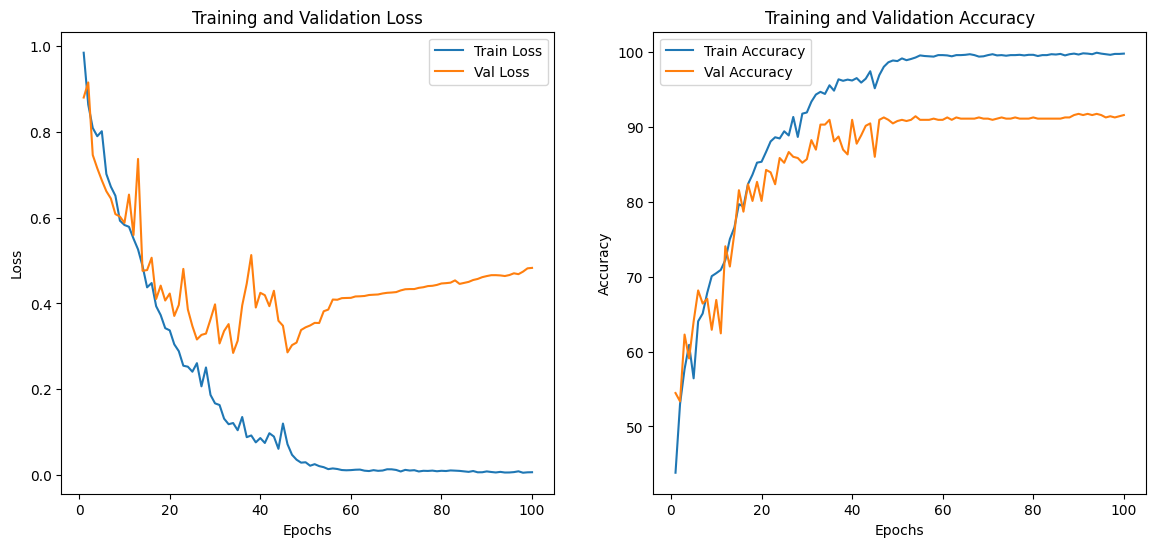

In [8]:

# Plotting training and validation losses and accuracies
epochs = range(1, len(train_losses) + 1)
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, val_losses, label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, label='Train Accuracy')
plt.plot(epochs, val_accuracies, label='Val Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.show()


In [9]:

# Test the model
model.eval()
test_correct = 0
test_total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)  # Move data to GPU
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()

test_accuracy = 100 * test_correct / test_total
print(f'Test Accuracy: {test_accuracy:.2f}%')

# Evaluate the model on the test set
model.eval()
predictions = []
true_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        predictions.extend(predicted)
        true_labels.extend(labels)

# Generate classification report
true_labels = torch.tensor(true_labels).cpu().numpy()
predictions = torch.tensor(predictions).cpu().numpy()
report = classification_report(true_labels, predictions, target_names=[f"Class {i}" for i in range(num_classes)])
print(report)


Test Accuracy: 90.59%
              precision    recall  f1-score   support

     Class 0       0.86      0.86      0.86       118
     Class 1       0.93      0.93      0.93       187
     Class 2       0.91      0.91      0.91       322

    accuracy                           0.91       627
   macro avg       0.90      0.90      0.90       627
weighted avg       0.91      0.91      0.91       627



In [10]:
from sklearn.metrics import confusion_matrix, classification_report, balanced_accuracy_score
import numpy as np

# Generate classification report and confusion matrix
print("Classification Report:")
print(classification_report(true_labels, predictions, target_names=[f"Class {i}" for i in range(num_classes)]))

cm = confusion_matrix(true_labels, predictions)
print("Confusion Matrix:")
print(cm)

# Calculate per-class metrics
TP = np.diag(cm)
FP = np.sum(cm, axis=0) - TP
FN = np.sum(cm, axis=1) - TP
TN = np.sum(cm) - (FP + FN + TP)

recall = TP / (TP + FN)
specificity = TN / (TN + FP)
precision = TP / (TP + FP)
f1_score = 2 * precision * recall / (precision + recall)

# Calculate macro-averaged metrics
macro_recall = np.mean(recall)
macro_precision = np.mean(precision)
macro_f1_score = np.mean(f1_score)
accuracy = np.sum(TP) / np.sum(cm)
balanced_accuracy = balanced_accuracy_score(true_labels, predictions)
custom_balanced_accuracy = np.mean((recall + specificity) / 2)

# Print class-wise metrics
print("\nClass-wise Metrics:")
for i in range(len(TP)):
    print(f"Class {i}:")
    print(f"  TP: {TP[i]}")
    print(f"  TN: {TN[i]}")
    print(f"  FP: {FP[i]}")
    print(f"  FN: {FN[i]}")
    print(f"  Recall: {recall[i]:.3f}")
    print(f"  Specificity: {specificity[i]:.3f}")
    print(f"  Precision: {precision[i]:.3f}")
    print(f"  F1-score: {f1_score[i]:.3f}")

# Print macro-averaged metrics
print("\nMacro-averaged Metrics:")
print(f"Macro Recall: {macro_recall:.3f}")
print(f"Macro Precision: {macro_precision:.3f}")
print(f"Macro F1-score: {macro_f1_score:.3f}")
print(f"Accuracy (ACC): {accuracy:.3f}")
print(f"Balanced Accuracy (BAC): {balanced_accuracy:.3f}")
print(f"Custom Balanced Accuracy (BCC): {custom_balanced_accuracy:.3f}")


Classification Report:
              precision    recall  f1-score   support

     Class 0       0.86      0.86      0.86       118
     Class 1       0.93      0.93      0.93       187
     Class 2       0.91      0.91      0.91       322

    accuracy                           0.91       627
   macro avg       0.90      0.90      0.90       627
weighted avg       0.91      0.91      0.91       627

Confusion Matrix:
[[102   0  16]
 [  0 174  13]
 [ 16  14 292]]

Class-wise Metrics:
Class 0:
  TP: 102
  TN: 493
  FP: 16
  FN: 16
  Recall: 0.864
  Specificity: 0.969
  Precision: 0.864
  F1-score: 0.864
Class 1:
  TP: 174
  TN: 426
  FP: 14
  FN: 13
  Recall: 0.930
  Specificity: 0.968
  Precision: 0.926
  F1-score: 0.928
Class 2:
  TP: 292
  TN: 276
  FP: 29
  FN: 30
  Recall: 0.907
  Specificity: 0.905
  Precision: 0.910
  F1-score: 0.908

Macro-averaged Metrics:
Macro Recall: 0.901
Macro Precision: 0.900
Macro F1-score: 0.900
Accuracy (ACC): 0.906
Balanced Accuracy (BAC): 0.901
Custo